# Inference with CPU, CUDA and TensorRT

Sources: 
- https://github.com/MariyaSha/Inference_withTorchTensorRT/blob/main/Inference.ipynb
- https://github.com/NVIDIA/TensorRT/blob/5f422623e7f5bdc593b781695cbddda99124c9b8/quickstart/IntroNotebooks/1.%20Introduction.ipynb
- https://github.com/NVIDIA/Torch-TensorRT/blob/master/notebooks/Resnet50-example.ipynb
- https://github.com/pytorch/TensorRT/blob/main/notebooks/dynamic-shapes.ipynb
- trtexec: https://catalog.ngc.nvidia.com/orgs/nvidia/containers/pytorch#cid=dl13_so-yout_en-us
- Inference Optimization with NVIDIA TensorRT: https://www.youtube.com/watch?v=UnIuMXGylfY
- dynamic shapes: https://pytorch.org/TensorRT/user_guide/dynamic_shapes.html

YOLO 
- quantization: https://medium.com/@abdelsalam.h.a.a/boosting-yolov5-performance-on-cpu-with-quantization-techniques-for-raspberry-pi4-too-dc2e24f68269
- ...

### Environment preparation
Using the docker container from the official Nvidia NGC Container:
https://catalog.ngc.nvidia.com/orgs/nvidia/containers/pytorch
```
    $ docker pull nvcr.io/nvidia/pytorch:21.12-py3
    $ docker run --net=host --gpus all -it --rm -v local_dir:/container_dir nvcr.io/nvidia/pytorch:21.12-py3
    $ jupyter notebook --allow-root --ip 0.0.0.0 --port 8888
    
```

trtexec --onnx=vae.onnx --saveEngine=vae.plan --minShapes=latent_sample:1x4x64x64 --optShapes=latent_sample:4x4x64x64 --maxShapes=latent_sample:8x4x64x64 --fp16



In [1]:
#docker run --net=host --gpus all -it --rm -v ${PWD}:/container_dir nvcr.io/nvidia/pytorch:23.09-py3

In [2]:
# !docker pull nvcr.io/nvidia/tritonserver:23.09-py3

In [3]:
import time
import numpy as np

from PIL import Image
from pathlib import Path

import torch
from torchvision import models, transforms#, Normalize
import torch.backends.cudnn as cudnn

from torchvision.models import resnet50, ResNet50_Weights

import onnx
import onnxruntime as onnxrt

import matplotlib.pyplot as plt
%matplotlib inline

cudnn.benchmark = True

### Load a pre-trained neural network

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
def load_classifier(torch_device):
    # initialize model with the best available weights
    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights)
    
    # initialize the inference transforms
    model_transform = weights.transforms(antialias=True)

    labels = weights.meta["categories"]
    
    return model, model_transform, labels

def postprocess(raw_scores_tensor, labels):
    softmax = torch.nn.Softmax(dim=-1)
    prediction = softmax(raw_scores_tensor.squeeze(0)).cpu().detach().numpy()
    class_ids = prediction.argsort()[::-1]

    scores = [prediction[class_id] for class_id in class_ids]
    category_names = [labels[class_id] for class_id in class_ids]

    # top 5
    topk = 5
    for i in range(0, topk):
        print(f"{category_names[i]}: {100 * scores[i]:.1f}%")

def classification_inference(model, preprocess, labels, image: Image, torch_device):
    model.to(torch_device)
    model.eval()
    
    # apply inference preprocessing transforms
    batch = preprocess(img).unsqueeze(0)
    batch = batch.to(torch_device)

    # use the model and print the predicted category
    with torch.no_grad():
        
        prediction = model(batch)
        postprocess(prediction, labels)
        

In [6]:
model, model_transform, labels = load_classifier(DEVICE)
print('num labels:', len(labels))
print('some of the labels: ', labels[0:10])

num labels: 1000
some of the labels:  ['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich']


briard: 9.5%
mask: 6.0%
teddy: 3.0%
Sussex spaniel: 1.5%
otterhound: 1.5%


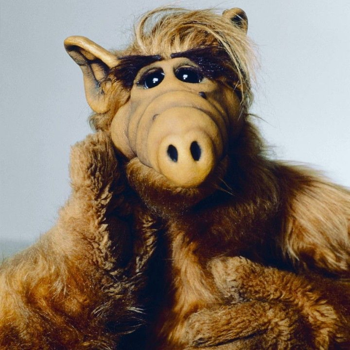

In [7]:
img = Image.open("./tritonserver/detection/images/alf.jpeg")
classification_inference(model, model_transform, labels, img, DEVICE)
img.resize((350, 350))

briard: 50.4%
otterhound: 2.2%
soft-coated wheaten terrier: 1.2%
Bouvier des Flandres: 0.6%
Tibetan terrier: 0.6%


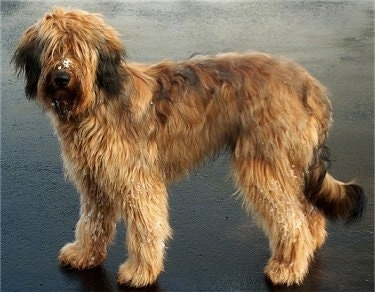

In [8]:
img = Image.open("./tritonserver/detection/images/Briard.jpg")
classification_inference(model, model_transform, labels, img, DEVICE)
img

In [10]:
# torch.hub._validate_not_a_forked_repo = lambda a, b, c: True

model.eval().to('cuda')
traced_model = torch.jit.trace(model, torch.randn(1, 3, 224, 224).to('cuda'))
torch.jit.save(traced_model, 'model.pt')

In [ ]:
1+1

# Benchmark method

In [ ]:
#copy from TRT

def benchmark(model, device="cuda", input_shape=(32, 3, 224, 224), dtype=torch.float32, nwarmup=50, nruns=100):
    input_data = torch.randn(input_shape).to(dtype)
    input_data = input_data.to(device)
        
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            features = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Iteration %d/%d, ave batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print("Output features size:", features)#.size())
    print('Average batch time: %.2f ms'%(np.mean(timings)*1000))

### Base model benchmark

In [ ]:
transformed_img = model_transform(img)
img_batch = torch.unsqueeze(transformed_img, 0)

In [ ]:
#CUDA benchmarks
model.to(DEVICE)
img_batch.to(DEVICE)
benchmark(model)

### Convert the model into an ONNX model

In [ ]:
!nvcc --version # CUDA VERSION

In [ ]:
#!whereis cudnn.h
#!CUDNN_H_PATH=$(whereis cudnn.h)
!cat /usr/include/cudnn_version.h | grep CUDNN_MAJOR -A 2

In [ ]:
!python -m pip install --upgrade pip

In [ ]:
!python -m pip uninstall -y onnxruntime 

In [ ]:
!python -m pip uninstall -y onnxruntime-gpu

In [ ]:
!python -m pip install onnxruntime-gpu --extra-index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/

In [ ]:
import onnxruntime as ort

In [ ]:
print(onnx.__version__)
print(ort.__version__)


In [ ]:
ort.get_device()

In [ ]:
def convert_to_onnx(model, model_transform, onnx_model_filepath, torch_device):
    
    dummy_image = np.random.rand(3, 224, 224)
    dummy_input = Image.fromarray(dummy_image, mode='RGB')
    
    dummy_input = model_transform(dummy_input)[None]
    dummy_input = dummy_input.to(torch_device)

    model.eval()
    model.to(torch_device)
    
    input_name = 'input' 
    output_name = 'output' 

    dynamic_axes_dict = {
        input_name: {
            0: 'bs'},
        output_name: {
            0: 'bs'}
    }

    Path(onnx_model_filepath).parent.mkdir(exist_ok=True, parents=True)
        
    torch.onnx.export(
        model,
        dummy_input,
        onnx_model_filepath,
        verbose=True,
        input_names=[input_name],
        output_names=[output_name],
        dynamic_axes=dynamic_axes_dict,
        export_params=True)
    

In [ ]:
convert_to_onnx(model, model_transform, 'classification_onnx.onnx', DEVICE)

In [ ]:
class OnnxModel():
    def __init__(self, onnx_model_filepath):
        providers = ['CUDAExecutionProvider']#, 'CPUExecutionProvider']

        self.onnx_session = onnxrt.InferenceSession(
            onnx_model_filepath, providers=providers)
        print("ONNX runtime session using :", onnxrt.get_device())
        
    def __call__(self, img_numpy):
      
        img_numpy = np.array(img_numpy.cpu())
        #print(img_numpy.shape)
        #x = torch.as_tensor(imgs, device='cuda')
        onnx_inputs = {self.onnx_session.get_inputs()[0].name: img_numpy}

        model_input = {'input': onnx_inputs['input']}

        onnx_output = self.onnx_session.run(None, input_feed=model_input)

        raw_results = onnx_output[0]

        return raw_results

def test_converted_classification_onnx_model(
    image_filepath, onnx_model_filepath, model_transform, labels):
    
    img = Image.open(image_filepath)
    
    imgs = model_transform(img)[None]
    
    model = OnnxModel(onnx_model_filepath)
    
    #imgs = torch.tensor(img, dtype='float32')[None]
    raw_results = model(imgs)
    
    scores = np.copy(raw_results)
    scores_tensors = torch.from_numpy(scores)

    postprocess(scores_tensors, labels)

In [ ]:
DEVICE

In [ ]:
test_converted_classification_onnx_model(
    './tritonserver/detection/images/alf.jpeg', 
    'classification_onnx.onnx',
    model_transform,
    labels
)

In [ ]:
onnx_model = OnnxModel('classification_onnx.onnx')

In [ ]:
benchmark(onnx_model)

### Convert the model into a TensorRT model

In [ ]:
!trtexec \
--onnx=classification_onnx.onnx \
--saveEngine=classification.plan \
--minShapes=input:1x3x224x224 \
--optShapes=input:8x3x224x224 \
--maxShapes=input:32x3x224x224 \
# --fp16 \
-explicitBatch \
--useCudaGraph

In [ ]:
!python -m pip install pycuda

In [ ]:
%%time

import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit

f = open("classification.plan", "rb")
runtime = trt.Runtime(trt.Logger(trt.Logger.WARNING)) 

engine = runtime.deserialize_cuda_engine(f.read())
context = engine.create_execution_context()

In [ ]:
USE_FP16 = True
target_dtype = np.float16 if USE_FP16 else np.float32
BATCH_SIZE = 1

In [ ]:
print(img.size)
img

In [ ]:
# Repeat across the batch dimension
input_batch = np.array(np.repeat(img_batch, BATCH_SIZE, axis=0), dtype=np.float32) 
input_batch.shape

In [ ]:
# need to set input and output precisions to FP16 to fully enable it
output = np.empty([BATCH_SIZE, 1000], dtype = target_dtype) 

# allocate device memory
d_input = cuda.mem_alloc(1 * input_batch.nbytes)
d_output = cuda.mem_alloc(1 * output.nbytes)

bindings = [int(d_input), int(d_output)]

stream = cuda.Stream()

In [ ]:
def predict(batch): # result gets copied into output
    # transfer input data to device
    cuda.memcpy_htod_async(d_input, batch, stream)
    # execute model
    context.execute_async_v2(bindings, stream.handle, None)
    # transfer predictions back
    cuda.memcpy_dtoh_async(output, d_output, stream)
    # syncronize threads
    stream.synchronize()
    
    return output

In [ ]:
import torch
from torchvision.transforms import Normalize

# def preprocess_image(img):
#     norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     result = norm(torch.from_numpy(img))#.transpose(0,2).transpose(1,2))
#     return np.array(result, dtype=np.float16)

preprocessed_images = np.array([image for image in input_batch])

In [ ]:
print("Warming up...")
pred = predict(preprocessed_images)
print("Done warming up!")

In [ ]:
%%timeit
pred = predict(preprocessed_images)

In [ ]:
indices = (-pred[0]).argsort()[:5]
print("Class | Probability (out of 1)")
list(zip(indices, pred[0][indices]))

In [ ]:
traced_model = torch.jit.trace(model, [torch.randn((32, 3, 224, 224)).to("cuda")])

In [ ]:
!python -m pip install --upgrade pip

In [ ]:
!python -m pip install onnxruntime

In [ ]:
!pip install torch-tensorrt

In [ ]:
!echo $CUDA_MODULE_LOADING

In [ ]:
# !set CUDA_MODULE_LOADING=LAZY

In [ ]:
# !unset $CUDA_MODULE_LOADING

In [ ]:
# !echo $CUDA_MODULE_LOADING

In [ ]:
# import os
# os.environ['CUDA_MODULE_LOADING'] = 'LAZY'

In [ ]:
import torch_tensorrt

In [ ]:
tensor_inputs = [torch_tensorrt.Input((32, 3, 224, 224), dtype=torch.float32)]

In [ ]:
trt_model = torch_tensorrt.compile(
    traced_model,
    inputs = tensor_inputs,
    enabled_precisions = {torch.float32}
)

In [ ]:
# !ldd /home/trtuser/.local/lib/python3.8/site-packages/torch_tensorrt/lib/libtorchtrt.so

In [ ]:
import torch
print(torch.__version__)
#torchvision 0.11.3+cu113 requires torch==1.10.2, but you have torch 2.0.1 which is incompatible.

In [ ]:
import torchvision
print(torchvision.__version__)

In [ ]:
import tensorrt
print(tensorrt.__version__)

In [ ]:
import torch_tensorrt
print(torch_tensorrt.__version__)

### TensorRT model speed benchmarks

In [ ]:
benchmark(trt_model, dtype=torch.float32)

 ### A prediction with the TensorRT model

In [ ]:
topk = 5

In [ ]:
trt_model.to(DEVICE)
trt_model.eval()

with torch.no_grad():
    img_batch_cuda = img_batch.to(DEVICE)
    outputs = trt_model(img_batch_cuda)
prob = torch.nn.functional.softmax(outputs[0], dim=0)

probs, classes = torch.topk(prob, topk)
for i in range(topk):
    probability = probs[i].item()
    class_label = labels[int(classes[i])]
    print("%{} {}".format(probability*100, class_label))

In [ ]:
#classification_inference(trt_model, model_transform, labels, img, DEVICE)

In [ ]:
trt_model.save('resnet101.plan')

In [ ]:
import torch_tensorrt

half_tensor_inputs = [torch_tensorrt.Input((32, 3, 224, 224), dtype=torch.half)]

trt_ts_module = torch_tensorrt.compile(traced_model,
    inputs = half_tensor_inputs,

    # For inputs containing tuples or lists of tensors, use the `input_signature` argument:
    # Below, we have an input consisting of a Tuple of two Tensors (Tuple[Tensor, Tensor])
    # input_signature = ( (torch_tensorrt.Input(shape=[1, 3, 224, 224], dtype=torch.half),
    #                      torch_tensorrt.Input(shape=[1, 3, 224, 224], dtype=torch.half)), ),

    enabled_precisions = {torch.half}, # Run with FP16
)
torch.jit.save(trt_ts_module, 'trt_torchscript_module.ts') # save the TRT embedded Torchscript


In [ ]:
benchmark(trt_ts_module, dtype=torch.half)

In [ ]:
trt_ts_module.to(DEVICE)
trt_ts_module.eval()

img_batch = torch.unsqueeze(img, 0).to(torch.float16)
with torch.no_grad():
    img_batch_cuda = img_batch.to(DEVICE)
    outputs = trt_ts_module(img_batch_cuda)
prob = torch.nn.functional.softmax(outputs[0], dim=0)

probs, classes = torch.topk(prob, topk)
for i in range(topk):
    probability = probs[i].item()
    class_label = labels[int(classes[i])]
    print("%{} {}".format(probability*100, class_label))

In [ ]:
compile_settings = {
    "inputs": [torch_tensorrt.Input(
        min_shape=[8, 3, 224, 224],
        opt_shape=[16, 3, 224, 224],
        max_shape=[32, 3, 224, 224],
        # For static size shape=[16, 3, 224, 224]
        dtype=torch.half, # Datatype of input tensor. Allowed options torch.(float|half|int8|int32|bool)
    )],
    "enabled_precisions": {torch.half}, # Run with FP16
}

trt_ts_module_dynamic = torch_tensorrt.compile(traced_model, **compile_settings)

In [ ]:
benchmark(trt_ts_module_dynamic, dtype=torch.half, input_shape=(8, 3, 224, 224))

In [ ]:
benchmark(trt_ts_module_dynamic, dtype=torch.half, input_shape=(16, 3, 224, 224))

In [ ]:
trt_ts_module_dynamic.save('resnet101_dynamic.plan')

In [ ]:
ls -la .

In [ ]:
!trtexec --onnx=models/model.onnx \
        --saveEngine=model.engine \
        --explicitBatch \
        --useCudaGraph

In [ ]:
!pwd

In [ ]:
# ls -la /

In [ ]:
# ls -la /home/trtuser